In [1]:


# import keras.dtensor.optimizers
#MATLABで作ったmatファイルを、matフォルダから読み取る
#matファイルは、変数がいくつか保存してあり、それぞれの中身を確認する
#matファイルの中身は、辞書型で保存されている
#辞書型の中身を確認するには、matlab.engineを使う
#matlab.engineを使うには、matlab.engineをインポートする必要がある

# !pip install tensorflow===2.11.0

# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()

In [2]:
#GPUを用いて、tensorflowを使ったseq2seq回帰LSTMモデルを作成する
import pandas as pd
# import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import scipy.io


In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2023-12-18 20:36:57.735294: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-18 20:36:58.211686: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1


2023-12-18 20:36:58.679514: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 20:36:58.700790: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 20:36:58.700992: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
#データの読み込み
mat_file = 'mat/60_sin_1period_bpsk_2signal.mat'
data = scipy.io.loadmat(mat_file)

#matファイルの中身の変数名を確認する

data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Num_tx', 'R_xx', 'R_xx_after_Noise', 'R_xx_exist_Noise', 'SNR_dB', 'fs', 'inputVec', 'label', 'noise', 's_t', 'sigmaX2', 'stter_vec', 't', 'x'])

In [5]:
a = data['R_xx']
# a = data['R_xx_exist_Noise']
b = data['inputVec']
c = data['label']

# d=data['sigmaX2']
# e=data['t']
#matに保存した変数の呼び出し
#a,b,cの次元数を確認する
print(a.shape)
print(b.shape)
print(c.shape)

#共分散行列
R = a


# #入力信号の電力
# sigmax2=d
# #スナップショット数
# t=e

#実数部と虚数部(虚数単位jは外す)に分ける関数
def split_complex(x):
    real = np.real(x)
    imag = np.imag(x)
    return real, imag


#実数部と虚数部に分ける
real, imag = split_complex(R)

#実数部と虚数部の次元数を確認する
print(real.shape)
print(imag.shape)

#実数部と虚数部を結合し、四次元配列に変換する
R = np.stack([real, imag], axis=3)

#Rの次元数を確認する
print(R.shape)

#Rはx(t)=As(t)+n(t)という信号モデルの共分散行列(Rはx(t)の複素共役転置の期待値)である（Aは方向行列、s(t)は入力信号、n(t)はガウス雑音）
#Rには、本来Aとs(t)とn(t)の情報が含まれているが、今回はn(t)を含まない
#Rにn(t)を乗せる処理を書く
#SNRを定義する
SNR = np.empty((1, 1))
np.append(SNR, 30)

#送信電力とSNRから雑音電力を求める
#送信電力は、sigmaX2である
#雑音電力は、sigmaN2である
# def calculate_noise_covariance(sigmaX2, SNR, t, R):
#     # 送信電力から雑音電力を計算する
#     # sigman2 = np.divide(sigmaX2, (10**(SNR/10)))
#     #
#     # # sigmaN2を表示する
#     # print(sigman2)
#     #
#     # # ガウス分布に従う雑音n(t)を生成する
#     # noise = np.sqrt(sigman2/2) * (np.random.randn(len(t),len(R[:,0,0,0])) + 1j*np.random.randn(len(t),len(R[:,0,0,0])))
#     #
#     # # n(t)の次元数を確認する
#     # print(noise.shape)
#
#     # # n(t)の共分散行列を求める
#     # N = np.dot(np.conj(noise).T, noise)
#     # N = N / len(t)
#     #
#     # # Nの次元数を確認する
#     # print("R_n", N.shape)
#
#     # Nの実部と虚部を分割する
#     real, imag = np.real(N), np.imag(N)
#
#     # Nを結合して次元数を確認する
#     N = np.stack([real, imag], axis=2)
#     print("R_n", N.shape)
#
#     return N




(10, 10, 1000)
(1000, 101)
(1000, 2)
(10, 10, 1000)
(10, 10, 1000)
(10, 10, 1000, 2)


array([ 0., 30.])

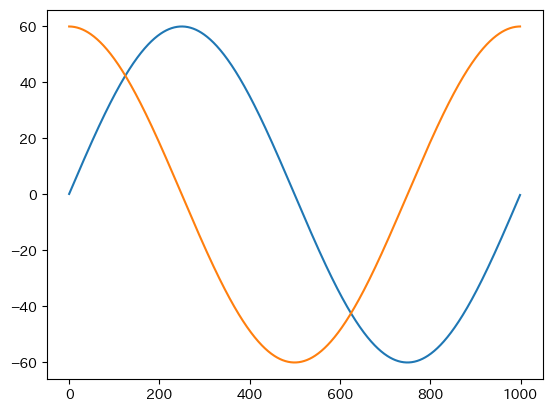

In [6]:
#tensorflowを使ったseq2seq回帰LSTMモデルを作成する

#matファイルで読み込んだinputVecとlabelからデータセットを作成する
#データセットは、inputVecとlabelの組み合わせで、入力と出力を作成する
X = R
Y = c

#Yをプロットする
plt.plot(Y)
plt.show()


In [7]:
#データセットを標準化する

#時系列画像データの標準化をする
#標準化すると、平均が0、標準偏差が1になる

from sklearn.preprocessing import StandardScaler

for j in range(X.shape[2]):
    for i in range(X.shape[3]):
        # シートごとのデータを抽出
        sheet_data = X[:, :, j, i]

        # 標準化器を作成し、データを標準化
        scaler = StandardScaler()
        sheet_data_standardized = scaler.fit_transform(sheet_data)

        # 標準化されたデータを元の配列に戻す
        X[:, :, j, i] = sheet_data_standardized



In [8]:
#データセットの特徴量の値の大部分が同じデータのみの場合にその行（もしくは列）を削除する

from sklearn.feature_selection import VarianceThreshold

for j in range(X.shape[2]):
    for i in range(X.shape[3]):
        sheet_data = X[:, :, j, i]  # シートごとのデータを抽出

        # VarianceThresholdを適用して行（もしくは列）を削除
        selector = VarianceThreshold()
        sheet_data_selected = selector.fit_transform(sheet_data)

        # 削除後のデータを元の配列に戻す
        if sheet_data_selected.ndim == 1:
            sheet_data_selected = sheet_data_selected.reshape(-1, 1)
        X[:, :, j, i] = sheet_data_selected

print(X.shape)

(10, 10, 1000, 2)


In [9]:
#Xを3次元配列に変換する
X = np.reshape(X, (X.shape[2], X.shape[0], X.shape[1], X.shape[3]))

print(X.shape)



(1000, 10, 10, 2)


In [10]:
from sklearn.model_selection import train_test_split

#学習データセットと検証データセットとテストデータセットの分割割合を変数で指定する
train_size = 0.8
val_size = 0.1
test_size = 0.1

#学習データセットと検証データセットとテストデータセットを分割する(シャッフルはしない)
XTrain, XTest, YTrain, YTest = train_test_split(X, Y, test_size=1 - train_size, shuffle=False)
XVal, XTest, YVal, YTest = train_test_split(XTest, YTest, test_size=test_size / (test_size + val_size), shuffle=False)

#学習データセットと検証データセットとテストデータセットの次元数を確認する
print(XTrain.shape)
print(XVal.shape)
print(XTest.shape)
print(YTrain.shape)
print(YVal.shape)
print(YTest.shape)

#入力の次元はそれぞれ(サンプル数、タイムステップ数、特徴量)である
#Xの2番目の次元と3番目の次元を入れ替える
XTrain = np.swapaxes(XTrain, 1, 2)
XVal = np.swapaxes(XVal, 1, 2)
XTest = np.swapaxes(XTest, 1, 2)


(800, 10, 10, 2)
(100, 10, 10, 2)
(100, 10, 10, 2)
(800, 2)
(100, 2)
(100, 2)


In [11]:
#GPUを使ったLSTMmodelの作成

#tensorflowのバージョンを確認する
print(tf.__version__)


2.12.1


In [12]:
# from tensorflow.python.keras.models import Sequential
# from tensorflow.python.keras import layers
# from tensorflow.python.keras import optimizers
# from tensorflow.python.keras.callbacks import ReduceLROnPlateau
# # from tensorflow.python.keras.callbacks import TensorBoard

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard


import tensorflow as tf


In [13]:
# # TensorFlowの設定を変更
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         # GPUメモリを必要に応じて割り当てるように設定
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)

In [14]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

#モデルの層の作成(cudNNLSTM層を使用するためのインポート)
# from tensorflow.keras.layers import 

print((XTrain.shape[1:]))



hidden_units = 128
# 入力データの形状
# データの形状
input_shape = (X.shape[1], X.shape[2], X.shape[3])
time_steps = X.shape[0]
output_units = 2  # 回帰問題なので出力のユニット数は1

## モデルの定義
model = Sequential()

# 入力を(timesteps, height, width, channels)の形状に変形する
# model.add(layers.Reshape((time_steps, image_height, image_width, channels), input_shape=(X.shape)))

# 畳み込み層1
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))

# batch_normalization
# model.add(normalization.normalization())

#relu
# model.add(layers.Activation('relu'))

#プーリング層
# model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# 畳み込み層2
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))

# batch_normalization
model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))

#relu
# model.add(layers.Activation('relu'))

#プーリング層
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# LSTM層に入力するために畳み込み層の出力を形状変換する
model.add(layers.Reshape((-1, 16)))

# LSTM層
model.add(layers.LSTM(units=hidden_units, return_sequences=True))
model.add(layers.LSTM(units=hidden_units, return_sequences=True))
model.add(layers.LSTM(units=hidden_units, return_sequences=True))
# 全結合層
model.add(layers.Dense(units=output_units))


early_stopping = EarlyStopping(
                        monitor='val_loss',
                        min_delta=0.0,
                        patience=10,
                )

# val_lossの改善が2エポック見られなかったら、学習率を0.5倍する。
reduce_lr = ReduceLROnPlateau(
                        monitor='val_loss',
                        factor=0.99,
                        patience=10,
                        min_lr=0.0001
                )

learning_rate = 0.01
opt = optimizers.Adam(learning_rate=learning_rate)


# opt = optimizers.adagrad_v2.Adagrad(learning_rate=learning_rate)
# コンパイル時にオプティマイザを指定する(損失関数はMSE、評価関数はRMSEをカスタムで実装)

loss_func = tf.keras.losses.MeanSquaredError(
    reduction='auto', name='mean_squared_error'
)

eval_func = tf.keras.metrics.RootMeanSquaredError(
    name='root_mean_squared_error', dtype=None
)

model.compile(loss=loss_func, optimizer=opt, metrics=eval_func)




(10, 10, 2)


2023-12-18 20:37:00.212042: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 20:37:00.212249: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 20:37:00.212391: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [16]:
import shutil
import os

path1 = 'logs/train'
path2 = 'logs/validation'

# ログファイルを削除
if os.path.exists('logs/train'):
    shutil.rmtree(path1)
if os.path.exists('logs/validation'):
    shutil.rmtree(path2)

# TensorBoardコールバックを作成
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./logs')
#plotをlocalhostで表示

#ターミナルにコマンドを打つ
# tensorboard --logdir logs


In [17]:

#モデルの学習

#モデルの学習の早期終了の設定
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
max_epochs = 100
mini_batch_size = 128

#モデルの学習
history = model.fit(XTrain, YTrain, batch_size=mini_batch_size, epochs=max_epochs, validation_data=(XVal, YVal),
                    callbacks=[reduce_lr,tensorboard])
#
#モデルの概要を表示する
model.summary()

Epoch 1/100


2023-12-18 20:37:00.841235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-18 20:37:00.842090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-18 20:37:00.842715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

InvalidArgumentError: Graph execution error:

Detected at node 'mean_squared_error/SquaredDifference' defined at (most recent call last):
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_45361/3361262107.py", line 9, in <module>
      history = model.fit(XTrain, YTrain, batch_size=mini_batch_size, epochs=max_epochs, validation_data=(XVal, YVal),
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/keras/engine/training.py", line 1109, in compute_loss
      return self.compiled_loss(
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/keras/losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/keras/losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/keras/losses.py", line 1470, in mean_squared_error
      return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)
Node: 'mean_squared_error/SquaredDifference'
required broadcastable shapes
	 [[{{node mean_squared_error/SquaredDifference}}]] [Op:__inference_train_function_9113]

In [ ]:
#モデルの評価

#モデルの評価
score = model.evaluate(XTest, YTest, verbose=1)

#モデルの評価結果を表示する
print('Test loss:', score[0])
print('Test accuracy:', score[1])


In [ ]:
#モデルの保存

#モデルの保存
model.save('model/LSTMmodel.h5')


In [ ]:
#モデルの読み込み

#モデルの読み込み
model = tf.keras.models.load_model('model/LSTMmodel.h5')

#モデルの概要を表示する
model.summary()

In [ ]:
#モデルの評価

#モデルの評価
score = model.evaluate(XTest, YTest, verbose=1)

#モデルの評価結果を表示する
print('Test loss:', score[0])
print('Test accuracy:', score[1])



In [ ]:
#モデルの予測

#モデルの予測

#予測値を格納する変数を作成する
YTestPred = np.zeros((YTest.shape[0], 1))

#予測値を計算する
YTestPred = model.predict(XTest)

#予測値を表示する
# print(YTestPred[:, 0, :])

df1 = pd.DataFrame(YTestPred[:, 0, :], columns=['Predicton'])
df2 = pd.DataFrame(YTest[:, 0], columns=['True'])

df = pd.concat([df1, df2], axis=1)

df


In [ ]:
#予測値と正解値のグラフを表示する
print(YTestPred[:, 0, 0].shape)
print(YTest.shape)

#予測値と正解値を一つのグラフに表示する
plt.plot(YTestPred[:, 0, 0], label='YTestPred', color='red')
plt.plot(YTest[:, 0], label='YTest', linestyle='dashed', color='blue')
plt.ylim(-90, 90)
plt.legend()
plt.show()


In [ ]:
#推定値と正解値との許容誤差が0～10の範囲内での平均二乗誤差の平方根をとった値のグラフを表示する

#推定値と正解値との許容誤差が0～10の範囲内での平均二乗誤差の平方根をとった値を計算する
YTestDiff = ((YTestPred[:, 0, 0] - YTest[:, 0]))

#推定値と正解値との許容誤差が0～10の範囲内での平均二乗誤差の平方根をとった値を表示する
print(YTestDiff.shape)

thr = np.arange(0, 10.5, 0.5)
numCorrect = np.zeros(len(thr))
numValidationImages = np.zeros(len(thr))
accuracy = np.zeros(len(thr))

for i in range(len(thr)):
    numCorrect[i] = np.sum(np.abs(YTestDiff) < thr[i])
    numValidationImages[i] = np.size(YTest[:, 0])
    accuracy[i] = numCorrect[i] / numValidationImages[i]

plt.scatter(thr, accuracy)
plt.xlabel("許容誤差(deg)")
plt.ylabel("accuracy")
plt.grid(True)
plt.plot(thr, accuracy, '.-', markersize=12)
plt.show()

In [ ]:
#予測値と正解値の差分のヒストグラムを表示する

#予測値と正解値の差分のヒストグラムを表示する
plt.hist(YTestDiff, bins=100)
plt.show()


In [ ]:
#予測値と正解値の差分の統計量を表示する

#予測値と正解値の差分の統計量を表示する
print(pd.DataFrame(YTestDiff).describe())


In [ ]:
#